In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import scipy.stats as stats

import folium
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import tools.helpers as th
import tools.data_preparation as dp
import tools.data_visualization as dv

%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
final_df = dp.initial_clean(df)

In [3]:
# import pandas as pd

# url = (
#     "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
# )
# state_geo = f"{url}/us-states.json"
# state_unemployment = f"{url}/US_Unemployment_Oct2012.csv"
# state_data = pd.read_csv(state_unemployment)

# m = folium.Map(location=[48, -102], zoom_start=3)

# folium.Choropleth(
#     geo_data=state_geo,
#     name="choropleth",
#     data=state_data,
#     columns=["State", "Unemployment"],
#     key_on="feature.id",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name="Unemployment Rate (%)",
# ).add_to(m)

# folium.LayerControl().add_to(m)



In [4]:
with open('data/king_county_zipcodes.geojson') as f:
    zipcode_geojson = json.load(f)

In [5]:
kc_zipcodes = final_df['zipcode'].unique()
zipcode_geojson['features'] = [feature for feature in zipcode_geojson['features'] if feature['properties']['ZIP'] in kc_zipcodes]

In [6]:
average_lat, average_long = final_df[['lat', 'long']].mean()
average_lat, average_long

(47.56009299439733, -122.21398249756845)

In [7]:
zipcode_avg_price = final_df.groupby('zipcode')[['price', 'lat', 'long']].mean().reset_index().sort_values('price', ascending=False)

zipcode_avg_price

zipcode         price        lat        long
24    98039  2.161300e+06  47.625840 -122.233540
3     98004  1.356524e+06  47.616183 -122.205189
25    98040  1.194874e+06  47.559846 -122.225592
48    98112  1.096239e+06  47.629619 -122.297866
41    98102  8.996077e+05  47.634591 -122.322250
..      ...           ...        ...         ...
61    98148  2.849086e+05  47.437437 -122.329316
0     98001  2.811949e+05  47.309106 -122.270704
20    98032  2.512962e+05  47.373556 -122.278848
64    98168  2.403284e+05  47.489700 -122.307877
1     98002  2.342840e+05  47.308780 -122.213357

[70 rows x 4 columns]

In [8]:
m = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    min_zoom=10,
    max_zoom=10,
    zoom_start=10
)

In [9]:
tooltips = folium.features.GeoJsonTooltip(
    fields=['ZIP']
)

In [10]:
highest_price, lat, long = zipcode_avg_price.iloc[0, 1:]

folium.Marker(
    location=[lat, long],
    tooltip=f"Average Price: ${highest_price:,.0f}"
).add_to(m);

In [11]:
choropleth = folium.Choropleth(
    geo_data=zipcode_geojson,
    data=zipcode_avg_price,
    columns=['zipcode', 'price'],
    key_on="feature.properties.ZIP",
    fill_color="Blues",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Sale Price ($)' 
)

choropleth.geojson.add_child(tooltips)
choropleth.add_to(m);

In [25]:
m

In [13]:
m.save('images/price_choropleth.png')

In [14]:
final_df['lat_cent'] = lat
final_df['long_cent'] = long
eval_formula = """
dist_from_center = ((lat - lat_cent)**2 + (long - long_cent)**2) ** 0.5
"""
final_df.eval(eval_formula, inplace=True)

In [15]:
# final_df = th.remove_outliers(final_df, 'price')

In [27]:
final_df.dist_from_center

0        0.117016
1        0.127902
2        0.112061
3        0.190947
4        0.188757
           ...   
21592    0.134327
21593    0.172509
21594    0.072619
21595    0.188192
21596    0.072749
Name: dist_from_center, Length: 21597, dtype: float64

<AxesSubplot:>

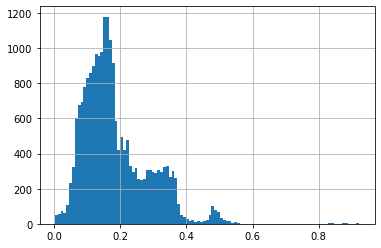

In [16]:
final_df['dist_from_center'].hist(bins='auto')

<AxesSubplot:xlabel='dist_from_center', ylabel='price'>

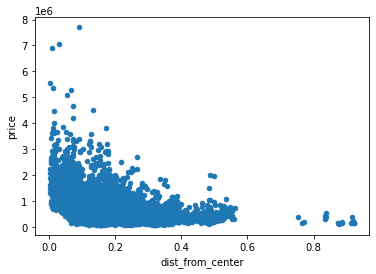

In [17]:
final_df.plot.scatter(x='dist_from_center', y='price')

In [18]:
model = smf.ols('price~dist_from_center', final_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     2856.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:47   Log-Likelihood:            -3.0605e+05
No. Observations:               21597   AIC:                         6.121e+05
Df Residuals:                   21595   BIC:                         6.121e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         7.754e+05   4987.591    155.466      0.000    7.66e+05    7.85e+05
dist_from_center -1.275e+06   2.39e+04    -53.437      0.000   -1.32e+06   -1.23e+06
==============================================================================
Omnibus:                    19433.648   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1335898.432
Skew:                           4.080   Prob(JB):                         0.00
Kurtosis:                      40.656   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

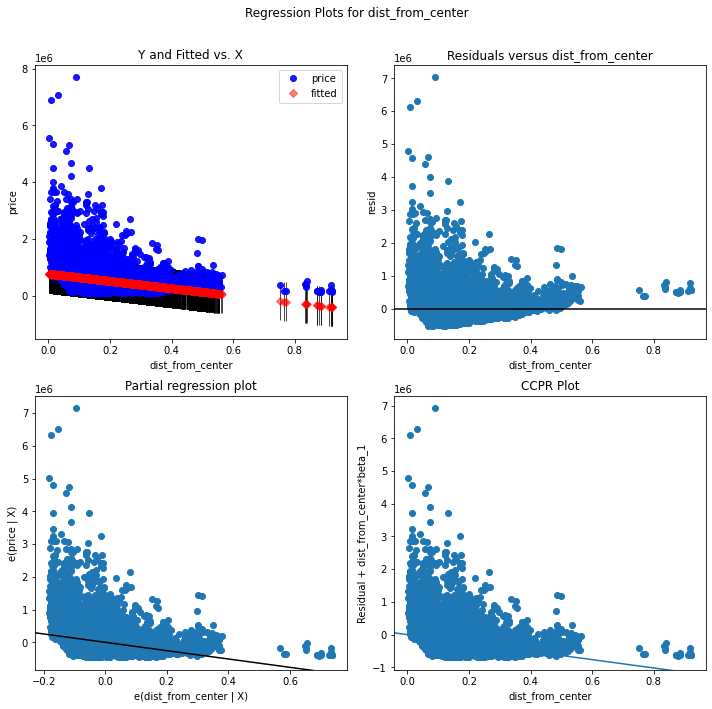

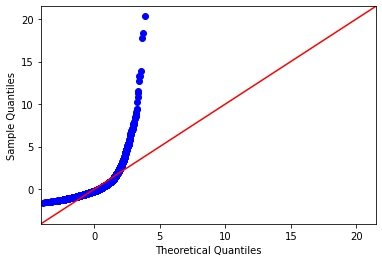

In [19]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(model, 'dist_from_center', fig=fig)
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [20]:
d = final_df.copy()
th.log_transform(d, 'dist_from_center')

<AxesSubplot:>

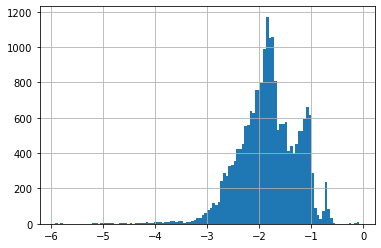

In [21]:
d['dist_from_center'].hist(bins='auto')

<AxesSubplot:xlabel='dist_from_center', ylabel='price'>

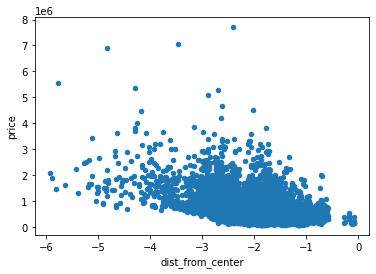

In [22]:
d.plot.scatter(x='dist_from_center', y='price')

In [23]:
log_model = smf.ols('price~dist_from_center', d).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5463.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:49   Log-Likelihood:            -3.0496e+05
No. Observations:               21597   AIC:                         6.099e+05
Df Residuals:                   21595   BIC:                         6.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2019.3993   7617.513      0.265      0.791   -1.29e+04     1.7e+04
dist_from_center -2.935e+05   3970.431    -73.911      0.000   -3.01e+05   -2.86e+05
==============================================================================
Omnibus:                    18886.939   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1275095.278
Skew:                           3.895   Prob(JB):                         0.00
Kurtosis:                      39.828   Cond. No.                         8.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

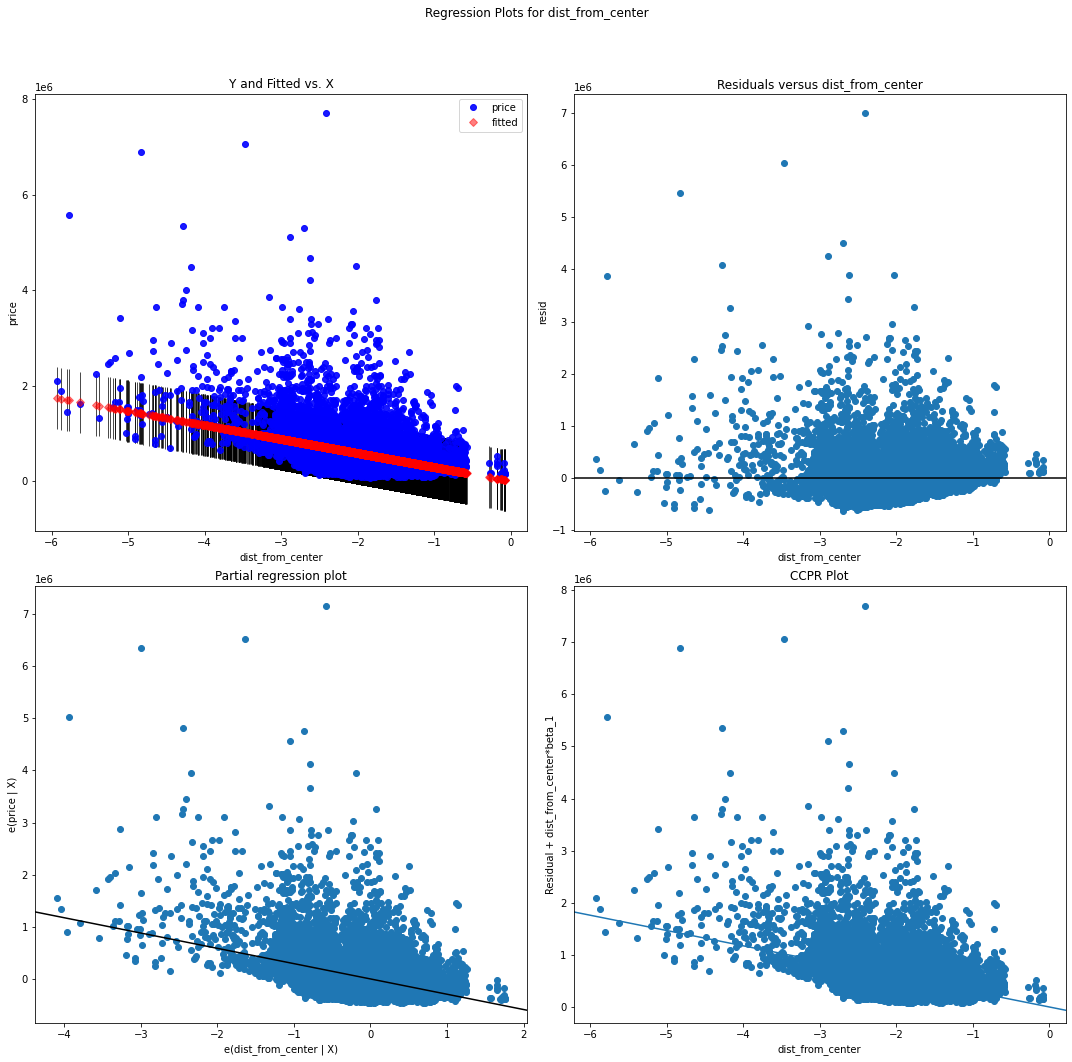

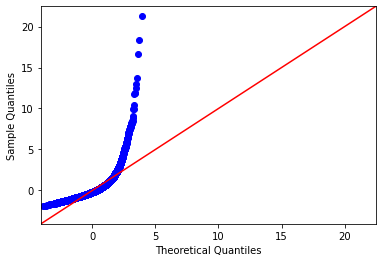

In [24]:
fig = plt.figure(figsize=(15, 15))
fig = sm.graphics.plot_regress_exog(log_model, 'dist_from_center', fig=fig)
fig = sm.graphics.qqplot(log_model.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
# def add_markers(data, m):
#     for row in data.itertuples(name=None):
#         folium.CircleMarker(
#         location=[row[2], row[3]],
#         radius=5,
#         tooltip=f"${row[1]:.2f}",
#         color='black',
#         stroke=False,
#         fill=True,
#         fill_color='black',
#         ).add_to(m)